# Intuitive Physics

In [1]:
import dataclasses
import pymunk
import matplotlib.pyplot as plt
from frozendict import frozendict
from flippy import keep_deterministic, uniform, condition, infer

## Simulation with a black box physics engine

In [2]:
@dataclasses.dataclass(frozen=True)
class Scene:
    fixed_object_params: tuple
    height: int = 600
    width: int = 500

    @keep_deterministic
    def run(self, object_params, timesteps=1000):
        space = self.space()
        objects_bodies = self.objects_and_bodies(object_params)
        for obj, body in objects_bodies.values():
            space.add(body, obj)
        obj_trajs = {
            i: [] for i, (o, _) in objects_bodies.items()
        }
        for t in range(timesteps):
            space.step(1/50)
            for obj_i, (obj, body) in objects_bodies.items():
                obj_trajs[obj_i].append(tuple(body.position))
        return obj_trajs
    
    @staticmethod
    def circle(x, y, radius, static):
        body = pymunk.Body(
            mass=1,
            moment=pymunk.moment_for_circle(
                mass=1,
                inner_radius=0,
                outer_radius=radius,
                offset=(0, 0)
            ),
            body_type=pymunk.Body.STATIC if static else pymunk.Body.DYNAMIC
        )
        body.position = x, y
        body.friction = 100
        body.angle = 0
        return pymunk.Circle(body=body, radius=radius), body
    
    @staticmethod
    def box(x, y, h, w, static):
        inertia = pymunk.moment_for_box(mass=1, size=(w, h))
        body_type = pymunk.Body.STATIC if static else pymunk.Body.DYNAMIC
        body = pymunk.Body(mass=1, moment=inertia, body_type=body_type)
        body.position = x, y
        body.friction = 100
        return pymunk.Poly.create_box(body, size=(w, h)), body

    def space(self):
        space = pymunk.Space()
        space.gravity = (0.0, -900.0)
        static_lines = [
            pymunk.Segment(
                space.static_body,
                pymunk.Vec2d(0, -35),
                pymunk.Vec2d(self.width, -35),
                40
            ),
            pymunk.Segment(
                space.static_body,
                pymunk.Vec2d(self.width+40, 0),
                pymunk.Vec2d(self.width+40, self.height),
                40
            ),
            pymunk.Segment(
                space.static_body,
                pymunk.Vec2d(-40, self.width),
                pymunk.Vec2d(-40, 0),
                40
            )
        ]
        for l in static_lines:
            l.friction = 100
        space.add(*static_lines)

        fixed_obj_bodies = self.objects_and_bodies(self.fixed_object_params)
        for obj, body in fixed_obj_bodies.values():
            space.add(body, obj)
        return space
    
    def objects_and_bodies(self, object_params):
        # note: we seem to need to return both the object and its body
        # due to how pymunk works
        objects_bodies = {}
        for name, kind, params in object_params:
            obj_body = getattr(self, kind)(**params)
            objects_bodies[name] = obj_body
        return objects_bodies
    
    def plot_scene(self):
        fig, ax = plt.subplots()
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_aspect('equal')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        return self.plot_objects(self.fixed_object_params, ax=ax)
    
    def plot_objects(self, object_params, ax=None):
        if ax is None:
            ax = self.plot_scene()
        objects_bodies = self.objects_and_bodies(object_params)
        for obj, body in objects_bodies.values():
            if isinstance(obj, pymunk.Circle):
                ax.add_patch(plt.Circle(
                    (obj.body.position.x, obj.body.position.y),
                    radius=obj.radius,
                    color='g' if obj.body.body_type == pymunk.Body.DYNAMIC else 'k',
                ))
            elif isinstance(obj, pymunk.Poly):
                vertices = [body.position + v for v in obj.get_vertices()]
                ax.add_patch(plt.Polygon(
                    vertices,
                    closed=True,
                    color='g' if body.body_type == pymunk.Body.DYNAMIC else 'k',
                ))
        return ax
    
    def plot_traj(self, traj, object_params=(), ax=None):
        if ax is None:
            ax = self.plot_scene()
        ax = self.plot_objects(object_params, ax=ax)
        for obj_i, obj_traj in traj.items():
            x, y = zip(*obj_traj)
            ax.plot(x, y, 'g.', markersize=4, alpha=.4)
            ax.plot(x[-1], y[-1], 'g*', markersize=15)
        return ax
    
    def run_and_plot(self, timesteps=1000):
        ax = self.plot_scene()
        traj = self.run()
        for obj_i, obj_traj in traj.items():
            x, y = zip(*obj_traj)
            ax.plot(x, y, 'g.', markersize=4, alpha=.4)
            ax.plot(x[-1], y[-1], 'g*', markersize=15)
        return ax

Final x (bin): 229


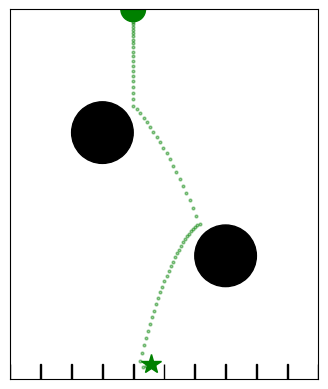

In [3]:
scene = Scene(
    fixed_object_params=[
        ('obstacle_1', 'circle', dict(x=150, y=400, radius=50, static=True)),
        ('obstacle_2', 'circle', dict(x=350, y=200, radius=50, static=True)),
        *[
            (f'bin_{i}', 'box', dict(x=i, y=0, h=50, w=1, static=True))
            for i in range(0, 550, 50)
        ]
    ],
    height=600,
    width=500
)

object_params = [
    ('dropped', 'circle', dict(x=200, y=600, radius=20, static=False))
]
traj = scene.run(object_params)
scene.plot_traj(traj, object_params=object_params)
print("Final x (bin):", int(traj["dropped"][-1][0]))

## Inference with a physics engine

In [4]:
@infer(method="LikelihoodWeighting", samples=1000)
def model(final_x):
    init_x = uniform()*500
    init_obj =  ("dropped", "circle", frozendict(x=init_x, y=600, radius=20, static=False))
    traj = scene.run([init_obj]) # this calls into the physics engine 
    final_x_ = traj['dropped'][-1][0]
    condition(abs(final_x_ - final_x) < 10)
    return init_obj

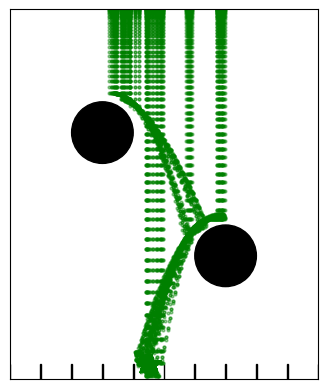

In [5]:
dist = model(229)
ax = scene.plot_scene()
for _ in range(100):
    init_obj = dist.sample()
    traj = scene.run([init_obj])
    scene.plot_traj(traj, ax=ax)